### Task 3: Heart Rhythm Classification

information provided: time series (original ECG recordings of different length)

to predict: heart rhythm into one of 4 classes

Evaluation metric: F-score

In [1]:
import pandas as pd
import numpy as np
import os
import csv

In [4]:
import biosppy.signals.ecg as ecg
from biosppy.plotting import plot_ecg
import scipy.signal
import scipy.stats
from tqdm import tnrange, tqdm_notebook

In [6]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test_data = pd.read_csv('X_test.csv')

In [57]:
X_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x7990,x7991,x7992,x7993,x7994,x7995,x7996,x7997,x7998,x7999
0,-863.0,-860.0,-857.0,-854.0,-851.0,-849.0,-846.0,-843.0,-838.0,-831.0,...,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0
1,-137.0,-132.0,-123.0,-107.0,-79.0,-59.0,-45.0,-47.0,-70.0,-107.0,...,244.0,245.0,247.0,250.0,251.0,251.0,247.0,242.0,234.0,225.0
2,-727.0,-736.0,-748.0,-784.0,-831.0,-874.0,-917.0,-967.0,-1029.0,-1112.0,...,-188.0,-186.0,-183.0,-180.0,-178.0,-176.0,-174.0,-171.0,-168.0,-164.0
3,-103.0,-98.0,-92.0,-87.0,-81.0,-77.0,-71.0,-65.0,-61.0,-59.0,...,-10.0,-2.0,11.0,22.0,32.0,41.0,45.0,48.0,51.0,55.0
4,8.0,2.0,-1.0,-3.0,-5.0,-7.0,-10.0,-12.0,-14.0,-14.0,...,233.0,233.0,233.0,233.0,233.0,233.0,233.0,233.0,233.0,233.0


In [9]:
# drop the id column
X_train = X_train.drop(['id'], axis = 1)
y_train = y_train.drop(['id'], axis = 1)
id_list = X_test_data['id'].values
X_test_data = X_test_data.drop(['id'], axis = 1)

In [10]:
# this function first truncates the dataframe and selects only the first seq_length columns
# then the missing values are filled with the last available value in that row
def prepare_data(data: pd.DataFrame, seq_length = 8500):
    data = data.iloc[:, :seq_length]
    data = data.fillna(method='bfill', axis=1)
    data = data.fillna(method='ffill', axis=1)
    return(data)

In [11]:
def get_bio_signals(signals: np.ndarray) -> dict:
    bio_signals = []
    for i in tnrange(signals.shape[0]):
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal=signals[i], sampling_rate=300, show=False)
        bio_signals.append({'ts': ts, 'filtered': filtered, 'rpeaks': rpeaks, 'templates_ts': templates_ts, 'templates': templates, 'heart_rate_ts': heart_rate_ts, 'heart_rate': heart_rate})
    return bio_signals

In [12]:
def find_num_peaks(signals, prominence = 300):
    peaks = np.asarray([scipy.signal.find_peaks(signals[i], prominence=prominence)[0].shape[0] for i in range(signals.shape[0])])
    return peaks

In [13]:

def extract_statistics(bio_signals):
    T = 1.0/300.0
    # signal statistics
    signal_stats = np.zeros((len(bio_signals), 6))
    for i in range(signal_stats.shape[0]):
        num_peaks = find_num_peaks(bio_signals[i]['templates'], prominence = 30)
        signal_stats[i, 0] = bio_signals[i]['filtered'].mean()
        signal_stats[i, 1] = np.var(bio_signals[i]['filtered'])
        signal_stats[i, 2] = scipy.stats.skew(bio_signals[i]['filtered'])
        signal_stats[i, 3] = scipy.stats.kurtosis(bio_signals[i]['filtered'])
        signal_stats[i, 4] = num_peaks.mean()
        signal_stats[i, 5] = num_peaks.max()
        #signal_stats[i, 2] = np.max(bio_signals[i]['filtered']) - np.min(bio_signals[i]['filtered'])

    # heart rate statistics
    hr_stats = np.zeros((len(bio_signals), 4))
    for i in range(hr_stats.shape[0]):
        if bio_signals[i]['heart_rate'].shape[0] == 0:
            continue
        hr_stats[i, 0] = bio_signals[i]['heart_rate'].mean()
        hr_stats[i, 1] = np.var(bio_signals[i]['heart_rate'])
        hr_stats[i, 2] = np.amax(bio_signals[i]['heart_rate'])
        hr_stats[i, 3] = np.amin(bio_signals[i]['heart_rate'])
    # rpeak statistics
    rr_int_stats = np.zeros((len(bio_signals), 11))
    for i in range(hr_stats.shape[0]):
        if bio_signals[i]['rpeaks'].shape[0] == 0:
            continue
        rr_int = np.diff(T*1000*bio_signals[i]['rpeaks'])
        rr_int_stats[i, 0] = rr_int.mean()
        rr_int_stats[i, 1] = np.var(rr_int)
        rr_int_stats[i, 2] = np.amin(rr_int)#scipy.stats.kurtosis(rr_int)
        rr_int_stats[i, 3] = np.amax(rr_int)#scipy.stats.skew(rr_int)
        rr_int_diff = np.abs(np.diff(rr_int))
        rr_int_stats[i, 4] = rr_int_diff.mean()
        rr_int_stats[i, 5] = np.var(rr_int_diff)
        rr_int_stats[i, 6] = np.amin(rr_int_diff) #scipy.stats.kurtosis(rr_int_diff)
        rr_int_stats[i, 7] = np.amax(rr_int_diff) #scipy.stats.skew(rr_int)
        rr_int_diff_sq = np.square(rr_int_diff)
        #rr_int_stats[i, 8] = rr_int_diff_sq.mean()
        #rr_int_stats[i, 9] = np.std(rr_int_diff_sq)
        #rr_int_stats[i, 10] = scipy.stats.kurtosis(rr_int_diff_sq)
        #rr_int_stats[i, 11] = scipy.stats.skew(rr_int)
        rr_int_stats[i, 8] = np.sqrt(np.mean(rr_int_diff_sq))
        # pnn 20/50
        rr_int_stats[i, 9] = np.sum(rr_int_diff > 20).astype(np.float32)/rr_int_diff.shape[0]
        rr_int_stats[i, 10] = np.sum(rr_int_diff > 50).astype(np.float32)/rr_int_diff.shape[0]

    # dft
    start = 15
    end = 20
    fourier = np.zeros((len(bio_signals), start + end))
    mean_qrs = np.zeros((len(bio_signals), 1))
    for i in range(len(bio_signals)):
        signal = bio_signals[i]['filtered']
        rpeaks = bio_signals[i]['rpeaks']
        qrs = np.asarray([signal[rpeaks[j] - start : rpeaks[j] + end] for j in range(rpeaks.shape[0])])
        f_t = np.fft.fft(qrs, axis=1)
        f_t = np.absolute(f_t)
        f_t = f_t.mean(axis=0)
        fourier[i] = f_t
        mean_qrs[i, 0] = qrs.mean(axis=0).mean()
    return np.concatenate((signal_stats, hr_stats, rr_int_stats, fourier, mean_qrs), axis=1)

### Preparing the training data
1. Truncating; Imputing missing values with the last appearing value in the Time Series
2. Extracting bio signals from the prepared training dataset
3. Manually extracting statitsics from the bio signals
4. Scaling the data

In [14]:
from sklearn.preprocessing import StandardScaler
X_train = prepare_data(X_train, seq_length = 8000)
bio_signals = get_bio_signals(X_train.values)
X_train_extracted = extract_statistics(bio_signals)
scaled = StandardScaler().fit_transform(X_train_extracted)

### Using different Classifiers (Best so far: XGBoost)

In [104]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='MultiClass',
                           eval_metric='TotalF1',
                           random_seed=42,
                           l2_leaf_reg=3,
                           verbose=True)

In [53]:
from lightgbm import LGBMClassifier

classifier = LGBMClassifier(colsample_bytree=0.9,   
                           objective='multi:softmax',
                           boosting_type='dart',
                           gamma=1,  
                           num_leaves=62,
                           learning_rate=0.2,
                           max_depth=6,       
                           min_child_weight=1,   
                           n_estimators=1000,                                                     
                           reg_alpha=3,       
                           reg_lambda=0.5,       
                           subsample=0.9,         
                           seed=42
                           )

In [16]:
import xgboost as xgb
from xgboost import XGBClassifier

classifier = XGBClassifier(colsample_bytree=0.9,   
                           objective='multi:softmax',
                           gamma=0.5,  
                           num_class=4,
                           learning_rate=0.2,
                           max_depth=6,       
                           min_child_weight=1,   
                           n_estimators=200,                                                     
                           reg_alpha=1.1,       
                           reg_lambda=0.45,       
                           subsample=0.6,         
                           seed=42
                           )

In [65]:
from keras.layers import Convolution1D
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout
from keras import backend as K

nb_filters = 500



In [68]:
from sklearn.model_selection import train_test_split

print(X_train_extracted.shape)
train_X, test_X, train_y, test_y = train_test_split(X_train_extracted, y_train, test_size=0.33, random_state=42)

nrows, ncols = train_X.shape
train_X.reshape(nrows, ncols, 1)

nrows, ncols = test_X.shape
test_X.reshape(nrows, ncols, 1)

model = Sequential()
model.add(Convolution1D(nb_filters, 3, input_shape=train_X.shape, activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution1D(nb_filters, 3, activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("ok")
batch_size=10
nb_epoch=10
model.fit(train_X, train_y, batch_size=batch_size,
          nb_epoch=nb_epoch, validation_data=(test_X, test_y))

(5117, 57)
ok


C:\Users\asana\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Error when checking input: expected conv1d_9_input to have 3 dimensions, but got array with shape (3428, 57)

### kfold CV and reporting f scores

In [22]:
y_train = y_train['y'].values

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [146]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier(iterations=4,
                                classes_count=4,
                                od_pval=1e-3,
                                depth=7,
                                learning_rate=1,
                                loss_function='MultiClass',
                                eval_metric='TotalF1',
                                random_seed=42,
                                l2_leaf_reg=10,
                                verbose=True)

classifier = LGBMClassifier(colsample_bytree=0.9,   
                            objective='multi:softmax',
                            gamma=1,  
                            num_leaves=62,
                            learning_rate=0.01,
                            max_depth=10,       
                            min_child_weight=1,   
                            n_estimators=1000,                                                     
                            reg_alpha=3,       
                            reg_lambda=0.5,       
                            subsample=0.9,         
                            seed=42
                           )

In [145]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

scores = []
kfold = StratifiedKFold(n_splits=5, random_state=42)

for train, test in kfold.split(X_train_extracted, y_train):
    train_X, eval_X, train_Y, eval_Y = X_train_extracted[train], X_train_extracted[test], y_train[train], y_train[test]
    scaler = StandardScaler().fit(train_X)
    train_X = scaler.transform(train_X)
    eval_X = scaler.transform(eval_X)
    
    classifier.fit(train_X, train_Y)
    scores.append(f1_score(eval_Y, classifier.predict(eval_X), average='micro'))
    
scores = np.asarray(scores)
scores.mean(), scores.std()

C:\Users\asana\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(0.8047661595796678, 0.008489192449336722)

### Selecting the most relevant bio-features

<BarContainer object of 57 artists>

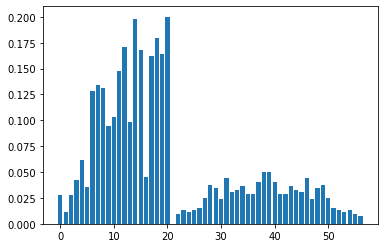

In [122]:
from sklearn.feature_selection import mutual_info_classif

mut_info_res = mutual_info_classif(X_train_extracted, y_train['y'].values, discrete_features=False, random_state=42)
import matplotlib.pyplot as plt
plt.bar(list(range(len(mut_info_res))), mut_info_res)

### Hyperparameter tuning for XGBoost 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler


# this is the Grid of hyperparameters to search over
hyperparameter_grid={
    'objective': ['multi:softmax'],
    'gamma': [0.5, 1, 2, 4],
    'max_depth': [6, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'min_child_weight': [1, 3, 4, 6],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'num_class': [4],
    'random_state': [42],
    'n_estimators': [150, 200, 250],
    'min_child_weight': [1, 2, 3, 4] 
}

scorer = make_scorer(f1_score , average='micro')

# this returns the best model
search = GridSearchCV(estimator=XGBClassifier(),    
                            param_grid=hyperparameter_grid,
                            cv=StratifiedKFold(n_splits=5, random_state=42),
                            scoring=scorer, #use f1 score
                            n_jobs=-1
                        )


search.fit(scaled, y_train['y'].values)

#### Fitting a model 

In [148]:
#classifier.fit(scaled, y_train['y'].values)
classifier.fit(scaled, y_train)

LGBMClassifier(colsample_bytree=0.9, gamma=1, learning_rate=0.01, max_depth=10,
               min_child_weight=1, n_estimators=1000, num_leaves=62,
               objective='multi:softmax', reg_alpha=3, reg_lambda=0.5, seed=42,
               subsample=0.9)

### Predictions on test data for submission

In [ ]:
X_test = prepare_data(X_test_data, seq_length = 8000)
bio_signals_test = get_bio_signals(X_test.values)
X_test_extracted = extract_statistics(bio_signals_test)
X_test_scaled = StandardScaler().fit_transform(X_test_extracted)

In [ ]:
y_pred_submission = classifier.predict(X_test_scaled)
sample_pd = pd.DataFrame({'id': id_list, 'y': y_pred_submission})
sample_pd.to_csv(r'sample_final_task3.csv', index = False)  
print("The csv file has been created successfully")

###  Best result without feature selection

#### if we perform feature selection based on mutual info

In [123]:
mut_info_threshold = 0.025 # got worse results with selecting features

X_train_selected = X_train_extracted[:, mut_info_res > mut_info_threshold]
X_train_scaled = StandardScaler().fit_transform(X_train_selected)

classifier.fit(X_train_scaled, y_train['y'].values)

X_test_selected = X_test_extracted[:, mut_info_res > mut_info_threshold]
X_test_scaled = StandardScaler().fit_transform(X_test_selected)


y_pred_submission = classifier.predict(X_test_scaled)
sample_pd = pd.DataFrame({'id': id_list, 'y': y_pred_submission})
sample_pd.to_csv(r'sample_final_task3.csv', index = False)  
print("The csv file has been created successfully")

The csv file has been created successfully


In [97]:
# saving them as csvs
X_test.to_csv(r'X_test_prepared.csv', index = False)  
pd.DataFrame(X_test_extracted).to_csv(r'X_test_extracted.csv', index = False) 